In [0]:
# general
import pandas as pd
import numpy as np
from collections import Counter

# pre-processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# parameter tuning
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import confusion_matrix, classification_report

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
# setting random_state for reproducibility. The same will be used throughout the whole code

random_state = 42

# Loading dataset, pre-processing and statistics

In [0]:
# loading data. Dataset description can be found on the report

features = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"] # "Severity" will be our target (0 = benign, 1 = malignant)
data = pd.read_csv("/content/drive/My Drive/ML exam/data/mammographic_masses.data", names=features)

In [0]:
data = data.iloc[:,1:6] # to discard "BI-RADS" which is a non-predictive attribute
data

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,?,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,?,1
...,...,...,...,...,...
956,47,2,1,3,0
957,56,4,5,3,1
958,64,4,5,3,0
959,66,4,5,3,1


From a first glance, it can be seen that **some values are missing** ("?"). This is a common problem in datasets. To solve this problem, first of all, I will replace them with a proper numPy NaN value.

In [0]:
data = data.replace("?", np.nan)
data.head(10)

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,NaN,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,NaN,1
5,65,1,NaN,3,0
6,70,NaN,NaN,3,0
7,42,1,NaN,3,0
8,57,1,5,3,1
9,60,NaN,5,1,1


In this case, the best way to handle these missing values is to **drop all the instances containing NaN**.

In [0]:
data.dropna(inplace=True) # dropping NaN values
data.reset_index(drop=True, inplace=True) # resetting indexes of dataframe for better handling later on
data

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,58,4,5,3,1
2,28,1,1,3,0
3,57,1,5,3,1
4,76,1,4,3,1
...,...,...,...,...,...
826,47,2,1,3,0
827,56,4,5,3,1
828,64,4,5,3,0
829,66,4,5,3,1


After removal, from the original 961 instances, we are now down to 831.

In [0]:
# a first look at the statistics

data.describe(include="all")

,Age,Shape,Margin,Density,Severity
count,831,831,831,831,831.000000
unique,72,4,5,4,NaN
top,67,4,1,3,NaN
freq,30,380,320,756,NaN
mean,NaN,NaN,NaN,NaN,0.484958
std,NaN,NaN,NaN,NaN,0.500075
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,1.000000


From the above output we can see bizarre NaN values, instead of expected numerical values. The problem may be that some of the **values are not encoded as integers**, but as strings, so that proper statistics are not shown. To check this, I will apply a filter.

In [0]:
data.applymap(np.isreal)

,Age,Shape,Margin,Density,Severity
0,False,False,False,False,True
1,False,False,False,False,True
2,False,False,False,False,True
3,False,False,False,False,True
4,False,False,False,False,True
...,...,...,...,...,...
826,False,False,False,False,True
827,False,False,False,False,True
828,False,False,False,False,True
829,False,False,False,False,True


As expected, probably none of them are encoded as integers ("Severity" column excluded). So in this step, I am going to **cast all the values into integers** to let them be properly handled.

In [0]:
for feat in features[1:5]:
    data[feat] = data[feat].apply(lambda x: int(x))

data.head(10)

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,58,4,5,3,1
2,28,1,1,3,0
3,57,1,5,3,1
4,76,1,4,3,1
5,42,2,1,3,1
6,36,3,1,2,0
7,60,2,1,2,0
8,54,1,1,3,0
9,52,3,4,3,0


Now all the values are integers and we can have a good account on the statistics.

In [0]:
data.describe()

,Age,Shape,Margin,Density,Severity
count,831.000000,831.000000,831.000000,831.000000,831.000000
mean,55.777377,2.783394,2.814681,2.915764,0.484958
std,14.663528,1.242331,1.566771,0.350737,0.500075
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,46.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


The above general statistics alone are not that informative. So, next step is **plotting the histograms** for all the features to check if there are anomalies, outliers or fairness issues that could influence the learning.

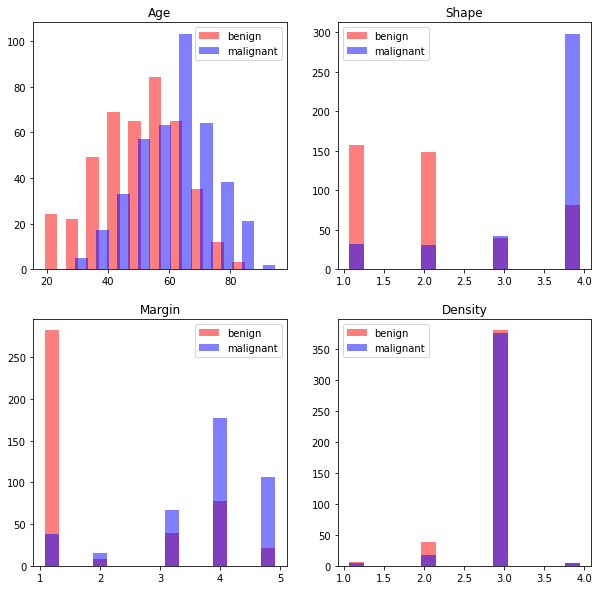

In [0]:
df_ben = data.loc[data["Severity"] == 0]
df_mal = data.loc[data["Severity"] == 1]

fig = plt.figure(1, figsize=(10.0,10.0))

feats = {1:"Age", 2:"Shape", 3:"Margin", 4:"Density"}

for k,v in feats.items():
    chart = fig.add_subplot(2,2,k)
    chart.title.set_text(v)
    chart.hist(df_ben[v], alpha=0.5, color='red', label='benign', rwidth=0.6)
    chart.hist(df_mal[v], alpha=0.5, color='blue', label='malignant', rwidth=0.6)
    if v in ("Shape", "Density"):
        chart.legend(loc='upper left')
    else:
        chart.legend(loc='upper right')

In [0]:
# counting exact "Severity" instances

Counter(data["Severity"])

Counter({0: 428, 1: 403})

From the statistics above, we can notice several things:

*   there are no anomalies, since all the values are within the features' expected ranges. In particular all the values for "Age" range from 18 to 96, those of "Shape" from 1 to 4, "Margin" from 1 to 5, "Density" from 1 to 4 and "Severity" contains only 0s and 1s.
*   malignant cases range between around 25 and 96 years of "Age", with a shift towards older ages, and a peak around 65 years-old.
*   "Shape" = 4 (*irregular*) is synonymous of malignity.
*   "Margin" = 1 (*circumscribed*), on the contrary, is synonymous of benign.
*   no clear-cut distinctions can be made within "Density" feature, since most of the values have value = 3 (*low*)
*   there will be no fairness issues and algorithms will not be biased, since the distribution of our target "Severity" is pretty balanced with 428 benign instances and 403 malignant.

After some pre-processing and statistical analysis, we are now approaching the proper Machine Learning part. First of all, we can notice that there are several different data types in this dataset. "Age" is **quantitative**, while the 3 features "Shape", "Margin" and "Density" are **categorical**. In particular, "Shape" and "Margin" are **nominal**, while "Density" is **ordinal**. The main difference between ordinal and nominal feature is that the numbers used to encode ordinal variables have some sort of logical sense (they are used to keep some meaning in the data), while in nominal, numbers are just chosen arbitrarly. Keeping this mix of different variable types may lead to some bad effects on the equations used by the classifiers. To solve this problem, I will try to blend them. I will create dummy variables for the 2 nominal features using scikit-learn **OneHotEncoder**, while keeping "Density" untouched to preserve the ordinal relationship. Our target "Severity" is **dichotomous**, and so no processing is needed.

In [0]:
onehotencoder = OneHotEncoder()
encod = pd.DataFrame(onehotencoder.fit_transform(data.iloc[:,1:3].to_numpy()).toarray())
encod

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
826,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
827,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
828,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
829,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


We can now compare the results of the encoding with the original data. Taking the first line of the 2 dataframes (you can see them right below this cell), it can be seen how the variables have been encoded. Let's take, for example the first feature "Shape": this feature originally ranges from 1 to 4, so in the encoded dataframe, the first 4 columns (0 to 3) will be attributed to feature "Shape". In particular, in the instance we selected, "Shape" gets value 3. This means that a value of 1 will be attributed to the 3rd column of the encoded dataframe, with the other values remaining 0. And that is exactly what happens! Then, "Margin" (ranging from 1 to 5) originally gets value 5 so the 9th column (4 attributed to "Shape" + 5 to "Margin") of the encoded dataframe will get the 1.

In [0]:
# first line of original dataframe

data.iloc[:,1:3].head(1)

,Shape,Margin
0,3,5


In [0]:
# first line of encoded dataframe

encod.head(1)

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's now concatenate the dataframes we need.

In [0]:
data_en = pd.concat([data["Age"], encod, data["Density"], data["Severity"]], axis=1)
data_en

,Age,0,1,2,3,4,5,6,7,8,Density,Severity
0,67,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3,1
1,58,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3,1
2,28,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,0
3,57,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,1
4,76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
826,47,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,0
827,56,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3,1
828,64,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3,0
829,66,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3,1


Another issue to solve before approaching the Machine Learning part is the imbalance due to the fact that data are not on the same scale (for instance, "Age" ranges from 18 to 96, "Density" from 1 to 4, while the other features are now binary). Since this problem may lead to inaccurate predictions, I will perform **feature scaling**.

In [0]:
data_sc = pd.DataFrame(MinMaxScaler().fit_transform(data_en))
data_sc

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.628205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.0
1,0.512821,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.0
2,0.128205,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0
3,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.0
4,0.743590,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
826,0.371795,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0
827,0.487179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.0
828,0.589744,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.0
829,0.615385,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.0


Next step is to **shuffle** and to **split** data into features **X** and target **y**.

In [0]:
data_sc = data_sc.sample(frac=1, random_state=random_state)

X = data_sc.iloc[:,0:11]
y = data_sc.iloc[:, 11]

In [0]:
X

,0,1,2,3,4,5,6,7,8,9,10
610,0.038462,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667
818,0.461538,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.666667
290,0.717949,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.666667
559,0.076923,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667
168,0.576923,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...
71,0.615385,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667
106,0.038462,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667
270,0.320513,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667
435,0.346154,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667


In [0]:
y

610    0.0
818    1.0
290    1.0
559    0.0
168    0.0
      ... 
71     0.0
106    0.0
270    0.0
435    1.0
102    1.0
Name: 11, Length: 831, dtype: float64

# Algorithm selection

As far as this problem is concerned, we are in the realm of **Supervised Machine Learning**, dealing with a **binary classification**. This means that all the input data are labeled with a category and that the classifiers, analyzing these data, will have to learn a function which can be used for mapping new unseen examples. In our specific case, inputs are vectors of 11 dimensions and the output is dichotomous or binary (0=benign or 1=malignant). Therefore, I decided to try out **all major ML algorithms for classification** using their default parameters, in order to set a **baseline** and check which one has more potential to be more accurate with some **fine tuning over parameters**. I will split the whole dataset in **train and test set**. The train set will be used for baseline and parameters tuning, and these results will be compared. I will keep the test set only for the very end to check how the best classifier performs on new unseen data. For the baseline and parameters tuning, I will use **5-fold cross validation**. This means that the data used will be split into 5 folds and each algorithm will run 5 times, each time picking one fold as test set, and the rest as training.



In [0]:
# splitting dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) # already shuffled before. 250 test samples

In [0]:
# baseline

models = [LogisticRegression(random_state=random_state),
          MultinomialNB(),
          KNeighborsClassifier(),
          SVC(random_state=random_state),
          LinearSVC(random_state=random_state),
          DecisionTreeClassifier(random_state=random_state),
          RandomForestClassifier(random_state=random_state),
          GradientBoostingClassifier(random_state=random_state),
          XGBClassifier(random_state=random_state)]

model = []
mean = []
std = []
mins = []
maxs = []

for clf in models:
    cross = cross_val_score(clf, X_train, y_train, cv=5) # 5-fold on train set
    model.append(type(clf).__name__)
    mean.append(cross.mean())
    std.append(cross.std())
    mins.append(min(cross))
    maxs.append(max(cross))

# creating dataframe for better fruition of results

result = pd.DataFrame({"Model":model, "Acc. mean":mean, "STD":std, "min":mins, "max":maxs})
result

,Model,Acc. mean,STD,min,max
0,LogisticRegression,0.795181,0.041299,0.724138,0.853448
1,MultinomialNB,0.789979,0.035780,0.741379,0.844828
2,KNeighborsClassifier,0.772782,0.028287,0.724138,0.801724
3,SVC,0.786561,0.038002,0.750000,0.853448
4,LinearSVC,0.791733,0.041328,0.724138,0.853448
5,DecisionTreeClassifier,0.703876,0.029845,0.672414,0.752137
6,RandomForestClassifier,0.738255,0.048825,0.681034,0.811966
7,GradientBoostingClassifier,0.755541,0.031484,0.715517,0.793103
8,XGBClassifier,0.772738,0.032458,0.715517,0.811966


From the above estimations, we can see a general positive trend. However, some of classifiers slightly outperform others. The ones which seem to behave more or less equivalently are worth exploring. So, I will pick the ones which have the mean accuracy value around 80% (**LogisticRegression** and **LinearSVC**) and try to **tune their parameters** to hopefully achieve better performance. Most notably, all tree-like classifiers behave generally worse compared to other types of classifiers.

I will now give a very quick overview on these 2 classifiers.
- **Logistic Regression** is a simple, but effective algorithm. It indeed frequently outperforms much more complex classifiers. It is appropriate to solve (binary) classification problems like ours. It basically analiyzes the relationship between dependent and independent variables and estimates the probability of an event to occur, using a logstic sigmoid function.
- **LinearSVC** is a Support Vector Machines (SVM) type algorithm. These type of classifiers try to find the optimal hyperplane that distinctly classifies the data points in an n-dimensional space. In a two dimensional space, for example, a hyperplane is a line that optimally divides the data points into two different classes. The further from the hyperplane our data points lie, the more confident we are that they have been correctly classified. The goal is to choose a hyperplane with the greatest possible margin (distance between the hyperplane and the nearest data point from either set) between the hyperplane and any point within the training set.

I will use Pipeline and GridSearch from scikit-learn to help me find the **best combination of parameters**.

In [0]:
# LogisticRegression parameters
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# LinearSVC parameters
loss = ['hinge', 'squared_hinge']

# shared parameters
penalty = ['l1', 'l2', 'elasticnet']
dual = [True, False]
tol = list(np.arange(0.0001,0.001,0.0001))
C = np.logspace(-4, 4, 20)

# creating a Pipeline object, a parameters grid and a GridSearch object
pipe = Pipeline([('classifier', LogisticRegression())]) # dummy needed to create Pipeline. The actual classifiers to compare are in the grid

param_grid = [
    {'classifier' : [LogisticRegression(max_iter=10000, random_state=random_state, n_jobs=-1)],
     'classifier__penalty' : penalty,
     'classifier__dual' : dual,
     'classifier__tol' : tol,
     'classifier__C' : C,
     'classifier__solver' : solver},
     {'classifier' : [LinearSVC(max_iter=10000, random_state=random_state)],
     'classifier__penalty' : penalty,
     'classifier__dual' : dual,
     'classifier__tol' : tol,
     'classifier__C' : C,
     'classifier__loss' : loss}]

clf = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, cv=5) # 5-folds to tune parameters using train data
best_clf = clf.fit(X_train, y_train)

The **best model** with the best parameters has finally been found!

In [0]:
best_clf.best_estimator_['classifier']

LogisticRegression(C=0.615848211066026, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
best_clf.best_score_

0.7968759210138521

The best classifier is a **LogisticRegression** model. The *best_score* reported above corresponds to the mean of accuracies of the 5 folds used by GridSearch on train data. So, this result can be compared to the accuracy mean achieved before with the baseline. This Logistic Regression model achieves a slightly higher value of mean accuracy with **0.796876** compared to the 0.795181 of the baseline.

# Results

I will now use this best classifier to make predictions over the new unseen data of the test set. I will then calculate **precision**, **recall**, **f1-score** and **confusion matrix**, to have a complete account on true positive, true negatives, false positives, and false negatives. In medical field, these metrics are all useful, since these cases will have to be treated differently. Our problem, which is avoiding unnecessary biopsies predicting the malignity of the mammographic masses, is no different.

[Text(33.0, 0.5, 'actual'), Text(0.5, 15.0, 'predicted')]

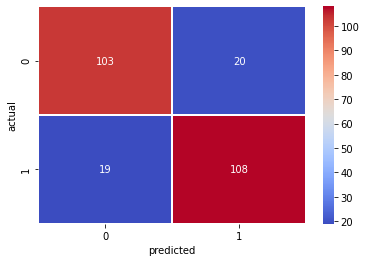

In [0]:
# predicting over test set
y_pred = best_clf.predict(X_test)

# plotting confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='coolwarm')
matrix.set(xlabel='predicted', ylabel='actual')

In [0]:
# prining out all the metrics

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       123
         1.0       0.84      0.85      0.85       127

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250



The problem we had to solve was to **reduce** the amount of unnecessary prescribed **biopsies**, due to inaccurate human interpretation of mammographic results (around 70% of biopsies turn out to be unnecessary). This means that **false positives** (detection of malignity when it is not present) are numerous. On new unseen data, our model achieves only **8%** (20/250) of false positives. This means that it rarely would "suggest" a biopsy when indeed it is not necessary. Unfortunately, it also predicts 7.6% of false negatives (19/250), where a mass is considered healthy while being indeed malignant. However, this model is really efficient in predicting **true positives** and **true negatives**, with precisions, recalls and f1-score (their harmonic mean) really high. All in all, our target has been centered, achieving a **drastic reduction** of the amount of unnecessary biopsies.